# Resizing and Data Augmentation

In this notebook we explore image resizing and data augmentation.  Image resizing is often necessary to prepare images for deep learning because the neural network models used expect square images and often expect images of particular dimensions like 256x256 or 224x224.  Data augmentation is a technique used to artificially increase the size of the training dataset by applying various transformations to the existing images, such as flipping, rotating, cropping, and changing the brightness or contrast. This helps to improve the model's generalization ability and reduce overfitting.

While these topics may seem unrelated, in the PyTorch ecosystem we use `torchvision.transforms` for both tasks.

## Image Resizing

Below we demonstrate three standard options for resizing an image to 256x256.  The first method is easy but distorts the image while the other two options preserve the aspect ratio of the original image but also lose some information.

We'll demonstrate the options using an image of a dog, but feel free to swap in your own image.

First we load the image and write a little helper function for showing an image.


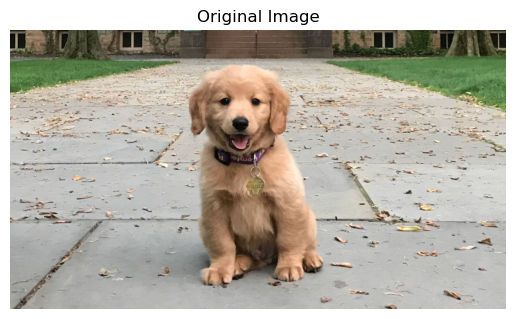

In [1]:
import os
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

# Function to display image
def show_image(img, title="Image"):
    plt.imshow(img)
    plt.title(title)
    plt.axis('off')
    plt.show()

# Load the image
image_path = 'pictures/dog.jpg'  # Replace with your image path
image = Image.open(image_path)

# Show the original image
show_image(image, title="Original Image")

Cute dog, right?  I got this image from a tutorial I went through about data augmentation that I went through last year, but I can't find the tutorial again...


---

### **1. Squishing the Image**

Squishing the image simply resizes it to 256x256 without preserving the aspect ratio. This can distort the image.

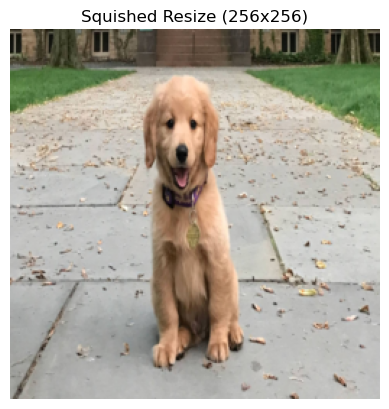

In [2]:
# Squishing to 256x256
resize_squish = transforms.Resize((256, 256))(image)

# Display squished image
show_image(resize_squish, title="Squished Resize (256x256)")

Pros: This is simple to do.
Cons: Image distortions may make it harder to neural network to learn image features.

Commonly used, but beware if your source images have small or large aspect ratios.



---

### **2. Center Cropping**

First we'll resize the image so that it's shortest side has 256 pixels, then we'll crop it to the center square.

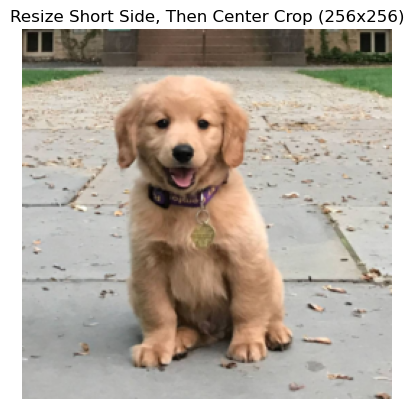

In [3]:
resize_transform = transforms.Resize(256) # resize so shortest side is 256 pixels
crop_transform = transforms.CenterCrop(256) # crop the center 256x256 pixels
center_cropped_image = crop_transform(resize_transform(image))

show_image(center_cropped_image, title="Resize Short Side, Then Center Crop (256x256)")

**Pros:**  This method is simple and efficient.  It preserves the aspect ratio of the image.

**Cons:**  This method may crop out important parts of the image.

Good to use if the images are usually centered on the main object.  If not, you may need to do some manual cropping or use a different method.


### **3. Padding**

First we'll resize the image so that its longest side has 256 pixels, then we'll pad the shorter side with zeros to make it 256 pixels long. This will result in a 256x256 image with the original image centered and padded with zeros around it.

`torchvision.transforms` has resizing and padding transforms that we can use to achieve this but we'll need a little logic to figure out which dimension to pad.  To do this we'll create a custom transform class that we could later use as part of an image processing pipeline in PyTorch.  This transform also makes use of `ImageOps` from the `PIL` package.

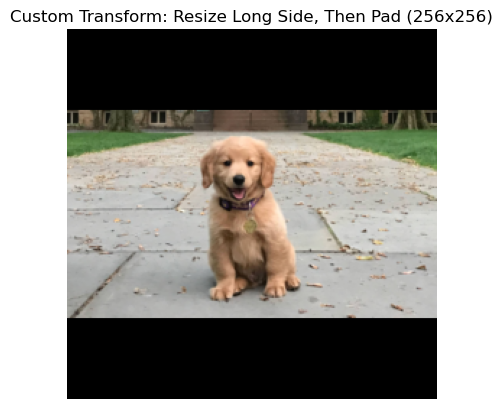

In [4]:
# Custom transform class to resize the longest side to 256 and pad to 256x256
class ResizeAndPad:
    def __init__(self, target_size=256):
        self.target_size = target_size

    def __call__(self, image):
        width, height = image.size
        
        # Resize based on the longest side
        if width > height:
            new_width = self.target_size
            new_height = int(height * self.target_size / width)
        else:
            new_height = self.target_size
            new_width = int(width * self.target_size / height)
        
        # Resize the image
        resized_image = image.resize((new_width, new_height), Image.BILINEAR)
        
        # Calculate padding for the shorter side
        pad_left = (self.target_size - new_width) // 2
        pad_right = self.target_size - new_width - pad_left
        pad_top = (self.target_size - new_height) // 2
        pad_bottom = self.target_size - new_height - pad_top
        
        # Pad the image to make it 256x256
        padded_image = ImageOps.expand(resized_image, (pad_left, pad_top, pad_right, pad_bottom))
        
        return padded_image

# Test the custom transform
custom_transform = ResizeAndPad(target_size=256)
padded_image = custom_transform(image)

# Show padded image
show_image(padded_image, title="Custom Transform: Resize Long Side, Then Pad (256x256)")


**Pros:** Preserves the content and aspect ratio of the orginal image.

**Cons:** Large images are compressed and lose some detail.

Use when preserving all of the image content is essential.

## Image Augmentation

PyTorch uses transforms to create new versions of images to create new versions of images to artificially enlarge the dataset so that our neural network models can better learn from the data.  The transforms are applied randomly and often in sequence so that the training images vary for each epoch. 

Below we demonstrate several commonly used augmentation transforms so you can get a sense of how each one works.

Below is a step-by-step approach, where each transformation is explained and then applied to the image individually. Each transformation will be presented in a separate code cell, and the output will be shown using `matplotlib`. This structure is designed for easy exploration of each transformation one by one, in a Jupyter notebook.

Here's the original image again for reference:

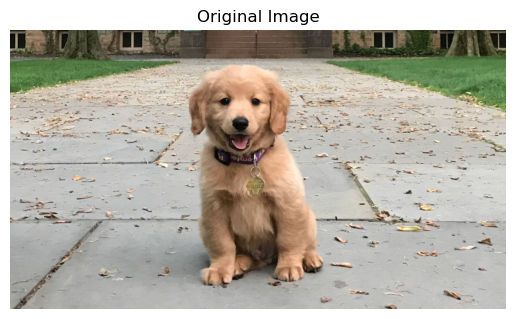

In [5]:
show_image(image,title="Original Image")


### 1. **Random Horizontal Flip**
Randomly flipping the image horizontally simulates different perspectives and helps the model become more robust.  Here the probability of flipping has been set to 1, but the default is 0.5.

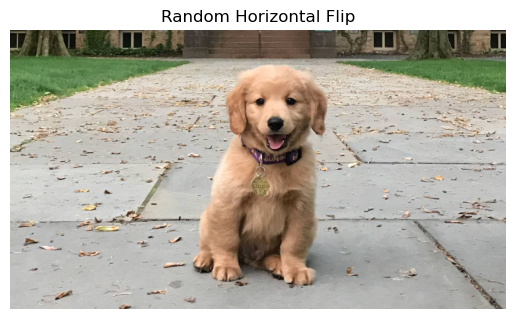

In [6]:
# Random Horizontal Flip
random_flip = transforms.RandomHorizontalFlip(p=1.0)  # Always flip for demonstration
flipped_image = random_flip(image)

# Display flipped image
show_image(flipped_image, title="Random Horizontal Flip")


---

### 2. **Random Vertical Flip**
Similar to horizontal flipping, this applies a vertical flip. Depending on the task, this may or may not be useful.  For example, radiological images often have an orientation so that a vertical flip doesn't make sense.

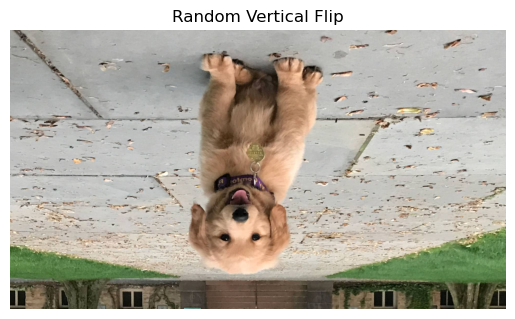

In [7]:
# Random Vertical Flip
random_vertical_flip = transforms.RandomVerticalFlip(p=1.0)  # Always flip for demonstration
flipped_image_v = random_vertical_flip(image)

# Display flipped image
show_image(flipped_image_v, title="Random Vertical Flip")

We probably wouldn't find upside down dogs in most datasets!



---

### 3. **Random Rotation**
Applying random rotations helps the model learn to deal with different orientations of objects.  It might make sense to randomly rotate before cropping an image depending on the application.  Try executing the cell a few times to see different randomly selected rotations.

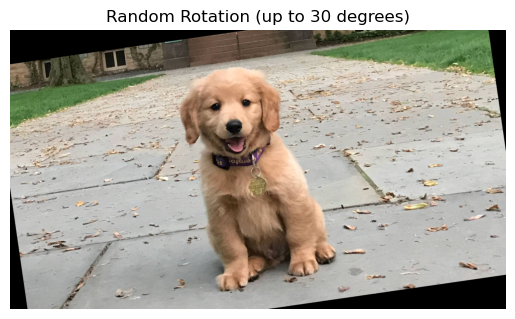

In [8]:
# Random Rotation
random_rotation = transforms.RandomRotation(30)  # Rotate by up to 30 degrees
rotated_image = random_rotation(image)

# Display rotated image
show_image(rotated_image, title="Random Rotation (up to 30 degrees)")


---

### 4. **Color Jittering**
This transformation randomly alters brightness, contrast, saturation, and hue, simulating different lighting conditions.  With the parameter values given below the images look like they were taken with different cameras and varying amounts of exposure so they're very typical of what you might find in a dataset of natural images.Try running this cell several times and play with the parameter values.  If you try a larger value of hue you can get some oddly colored dogs!

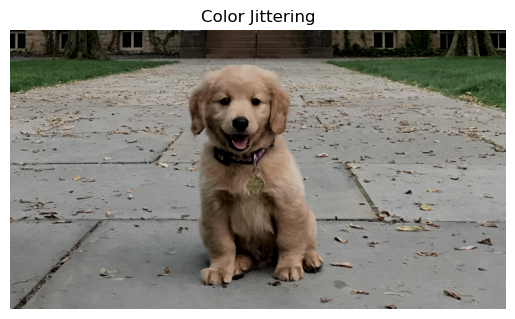

In [19]:
# Color Jittering
color_jitter = transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.1)
jittered_image = color_jitter(image)

# Display jittered image
show_image(jittered_image, title="Color Jittering")


---

### 5. **Random Grayscale**
Randomly converting the image to grayscale can help focus the model on texture and shape.

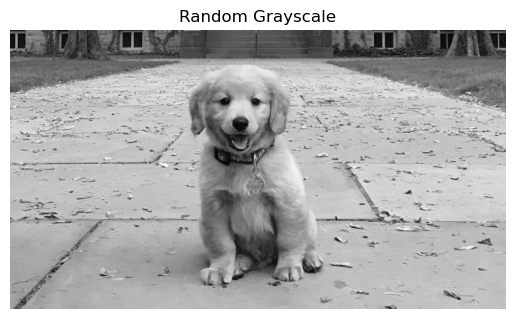

In [58]:
# Random Grayscale
random_grayscale = transforms.RandomGrayscale(p=1.0)  # Always convert to grayscale for demonstration
grayscale_image = random_grayscale(image)

# Display grayscale image
show_image(grayscale_image, title="Random Grayscale")



---

### 6. **Random Crop**
This transformation randomly crops the image, simulating zooming in or changing the viewpoint.  If the desired crop size is larger than the image dimensions padding can be added in various ways.  In this case, the original dog images is 1920x1080 so a 256x256 square may miss the dog entirely.  Try executing the cell below a few times to see if you get a picture that includes part of the dog:

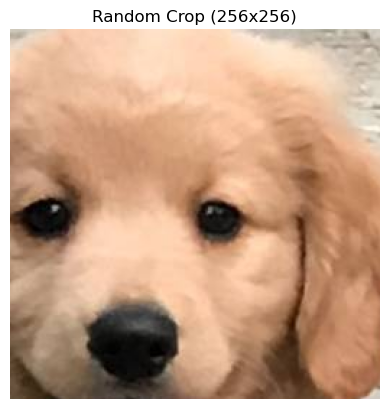

In [27]:
# Random Crop
random_crop = transforms.RandomCrop(256)
cropped_image = random_crop(image)

# Display cropped image
show_image(cropped_image, title="Random Crop (256x256)")

Since we have such a variation in sizes between our crop and the original image we can consider another transform called `transforms.RandomResizedCrop`.  It randomly selects a relatively sized crop in the range specified by its scale argument, then resizes that crop to the desired size. The ratio range determines the possible aspect ratios (W/H).  You can make both arguments 1.0 if you want to preserve aspect ratio.

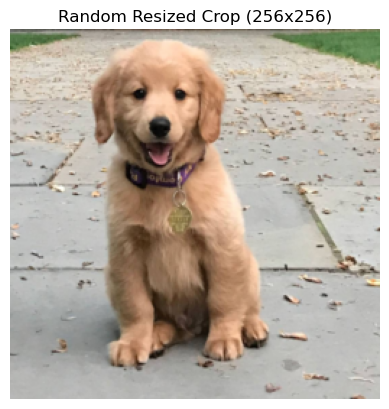

In [37]:
# Random Resized Crop
random_crop = transforms.RandomResizedCrop(size=256,scale=(0.5, 1.0),ratio=(7/8,8/7))
cropped_image = random_crop(image)

# Display cropped image
show_image(cropped_image, title="Random Resized Crop (256x256)")

Sometimes we have images that are already sized to the dimensions we need, but we want to use random cropping so that the network can learn to handle objects in different positions.  In this scenario we can use Random Crop with padding.  We'll apply it to the center-cropped version of the dog image from the first part of the notebook.  You may have to go back and run that cell again.

Try running the cell below a few different times.  You can also try other padding_modes such as 'reflect' or 'edge'.

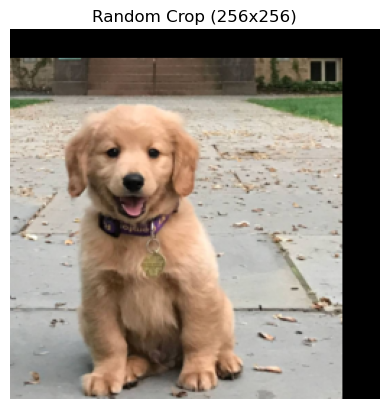

In [53]:
# Random Crop
random_crop = transforms.RandomCrop(256, padding=40, padding_mode='constant', fill=0)
cropped_image = random_crop(center_cropped_image)

# Display cropped image
show_image(cropped_image, title="Random Crop (256x256)")

### 7. **Normalization**

Normalization is a process of scaling the pixel values of an image to a fixed range. In the context of machine learning models, normalization is often performed on input data to help the model converge faster during training.  It's not really part of data augmentation, but we include it here so you can see the visual effect.  In this case we're using the means and standard deviations of the RGB channels in the ImageNet dataset.  These are often used normalize natural images.

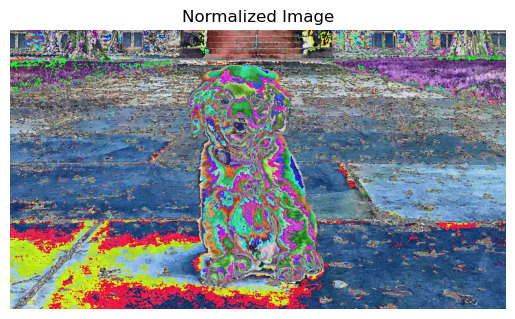

In [78]:

# Normalization (for demonstration, converting image to tensor and normalizing)
transform_to_tensor = transforms.ToTensor()  # First convert to tensor
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

tensor_image = transform_to_tensor(image)  # Convert image to tensor
normalized_image = normalize(tensor_image)

# Convert back to PIL to display
normalized_image_display = transforms.ToPILImage()(normalized_image)

# Display normalized image
show_image(normalized_image_display, title="Normalized Image")

Visually, that looks terrible, but normalization helps models converge faster in two main ways:

1. It reduces the impact of differences in pixel value ranges between images. This is important because different images may have different brightness levels or color distributions. By normalizing the pixel values, we make the images more comparable and ensure that the model focuses on the patterns and features in the images rather than the absolute pixel values.
2. It helps in stabilizing the learning process of the model during training. Normalization brings the pixel values to a similar scale, which can prevent the model from getting stuck in local optima or converging slowly. It can also help in avoiding numerical instability issues that may arise due to large pixel value ranges.
---

## A final note on combining resizing and augmentation

In deep learning pipelines, data augmentation is typically applied **before** resizing and cropping an image. Here's why:

- **Preserves Image Quality**: Augmentations like rotations, flips, color jittering, and random noise are more effective when applied to the original high-resolution image. Applying them before resizing ensures that the augmentations do not introduce artifacts or lose detail due to downscaling.
- **Better Generalization**: By performing augmentations on the original image, you ensure that the model sees a variety of transformed data with more diverse variations, which improves the model’s ability to generalize.

Te one common exception to this is that cropping (random or center) is often applied after resizing to get a final fixed-size input (e.g., 224x224 for ImageNet). Random cropping can serve as a form of augmentation, ensuring the model sees different sections of the image in each epoch.

